Yelnur Shauketbek: FFN classification problem

In [ ]:
!pip install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13 

In [2]:
import torch
import torch.nn.functional as F
from torchinfo import summary
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier 
from skorch.helper import SliceDataset
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import os
from timeit import default_timer as timer

In [3]:
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(42)
rng = np.random.default_rng(seed=4242)

torch.__version__='1.13.1+cu117'
device=device(type='cuda')
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA GeForce RTX 3060, 531.41, 12288 MiB, 957 MiB, 11171 MiB


In [4]:
train, test = AG_NEWS(root="dataset", split=('train', 'test'))
Tr, Ts = list(train), list(test)
rng.shuffle(Tr)
rng.shuffle(Ts)
len_train, len_val, len_test = 10000, 1000, 1000
train_data, val_data, test_data = Tr[:len_train], Ts[:len_val], Ts[len_val:len_val+len_test]

In [9]:
idx = 10
sample_label, sample_text = train_data[idx]
print(f"Text: {sample_text}")
print(f"Label: {sample_label}")

Text: Vancouver man is victim of shoddy FBI investigation: lawyer (Canadian Press) Canadian Press - VANCOUVER (CP) - A Vancouver man wanted by the U.S. for the 30-year-old murder of an American Indian Movement activist is being persecuted based on a faulty FBI investigation and the word of a troubled drug addict, says the lawyer defending his so-called partner in crime.
Label: 1


In [5]:
tokenizer = get_tokenizer('basic_english')
print("Example: ", tokenizer("I am so HAPPY to study Deep Learning! #UNIPD #UniLIFE"))

Example:  ['i', 'am', 'so', 'happy', 'to', 'study', 'deep', 'learning', '!', '#unipd', '#unilife']


In [6]:
def create_tokens(dataset):
  for sample in dataset:
    yield tokenizer(sample[1])

# We limit our model to learn from the first 1000 most frequent tokens
vocab = build_vocab_from_iterator(create_tokens(train_data), specials=["<unk>"], max_tokens=1000) # <unk> is the index we use for specials characters ...
vocab.set_default_index(vocab["<unk>"]) # ... and as 0 the default values for tokens out of the vocabulary (OOV)
print(f"Our vocabulary is made of {len(vocab)} tokens-index pairs.")

Our vocabulary is made of 1000 tokens-index pairs.


In [7]:
# Let us define some useful functions to handle tokens and labels
text_pipeline = lambda x: vocab(tokenizer(x)) # function to go from string -> tokens
label_pipeline = lambda x: int(x) - 1 # function to label starting form 0 for indexing

In [10]:
sample_tokenization = text_pipeline(sample_text)
sample_label_idx = label_pipeline(sample_label)
print(f"Samlpe headline text:\n {sample_text}")
print(f"Sample headline to tokens:\n {sample_tokenization}")
print(f"Label:\n {sample_label}")
print(f"Label index:\n {sample_label_idx}")

Samlpe headline text:
 Vancouver man is victim of shoddy FBI investigation: lawyer (Canadian Press) Canadian Press - VANCOUVER (CP) - A Vancouver man wanted by the U.S. for the 30-year-old murder of an American Indian Movement activist is being persecuted based on a faulty FBI investigation and the word of a troubled drug addict, says the lawyer defending his so-called partner in crime.
Sample headline to tokens:
 [0, 415, 23, 0, 6, 0, 0, 963, 0, 13, 313, 262, 14, 313, 262, 15, 0, 13, 780, 14, 15, 5, 0, 415, 0, 24, 2, 51, 1, 9, 1, 11, 2, 0, 0, 6, 31, 159, 637, 0, 0, 23, 264, 0, 0, 10, 5, 0, 0, 963, 8, 2, 0, 6, 5, 0, 380, 0, 3, 82, 2, 0, 0, 34, 0, 0, 7, 0, 1]
Label:
 1
Label index:
 0


In [11]:
def multi_hot(token_list, n_cat=len(vocab)):
  encoded = [1 if i in token_list else 0 for i in range(n_cat)]
  return encoded

In [12]:
class AGNewsDataset(Dataset):
  def __init__(self, dataset):
    super().__init__()
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    label, text = self.dataset[idx]
    lb = label_pipeline(label)
    txt = multi_hot(text_pipeline(text))
    lb, txt = torch.tensor(lb, dtype=torch.uint8, device=device), torch.tensor(txt, dtype=torch.float32, device=device)
    return lb, txt

In [13]:
train_dataset = AGNewsDataset(train_data)
val_dataset = AGNewsDataset(val_data)
test_dataset = AGNewsDataset(test_data)

In [14]:
batch_size = 256
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class FeedforwardNetwork(nn.Module):
  
  def __init__(self, input_dim, num_classes, hidden_layers_dim=[]):
    super().__init__()
    self.layers = nn.ModuleList()
    if len(hidden_layers_dim) == 0:
      self.layers = self.layers.append(nn.Linear(input_dim, num_classes))
    else:
      for layer_idx in range(len(hidden_layers_dim)):
        if layer_idx == 0:  # first layer, from input to hidden
          self.layers = self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
        else:  # hidden layers, depending on the input
          self.layers = self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
      self.layers = self.layers.append(nn.Linear(hidden_layers_dim[-1], num_classes))  # final output layer
    self.apply(self._init_weights)
    
  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=.1)
        if module.bias is not None:
            module.bias.data.zero_()
  
  def forward(self, x):
    if len(self.layers) == 1:
      return self.layers[0](x)
    else:
      for layer in self.layers[:-1]:
        x = F.relu(layer(x))
    return self.layers[-1](x)

In [16]:
# Now we prepare our model for this specific dataset
num_class = len(set([label for (label, text) in train_data]))
vocab_size = len(vocab)
EPOCHS = 40
lr = 1e-4
model = FeedforwardNetwork(vocab_size, num_class, hidden_layers_dim=[64, 64]).to(device)
summary(model, (batch_size, vocab_size)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
FeedforwardNetwork                       [256, 4]                  --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [256, 64]                 64,064
│    └─Linear: 2-2                       [256, 64]                 4,160
│    └─Linear: 2-3                       [256, 4]                  260
Total params: 68,484
Trainable params: 68,484
Non-trainable params: 0
Total mult-adds (M): 17.53
Input size (MB): 1.02
Forward/backward pass size (MB): 0.27
Params size (MB): 0.27
Estimated Total Size (MB): 1.57

In [17]:
# We need to defin our loss function (Cross Entropy for multiclass classification) and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [18]:
def train(model, optimizer, dataloader_train, dataloader_val, EPOCHS=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(EPOCHS):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [19]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 28.64%, Loss: 1.37913513 ---------------- Val_Acc: 31.20%, Val_Loss: 1.37503576
epoch: 2 -> Accuracy: 36.15%, Loss: 1.35842133 ---------------- Val_Acc: 37.60%, Val_Loss: 1.35475576
epoch: 3 -> Accuracy: 43.21%, Loss: 1.33493888 ---------------- Val_Acc: 43.90%, Val_Loss: 1.32880688
epoch: 4 -> Accuracy: 50.03%, Loss: 1.30309188 ---------------- Val_Acc: 51.20%, Val_Loss: 1.29239726
epoch: 5 -> Accuracy: 55.87%, Loss: 1.25794160 ---------------- Val_Acc: 58.20%, Val_Loss: 1.24086499
epoch: 6 -> Accuracy: 61.50%, Loss: 1.19568813 ---------------- Val_Acc: 63.90%, Val_Loss: 1.17141378
epoch: 7 -> Accuracy: 66.12%, Loss: 1.11570477 ---------------- Val_Acc: 67.90%, Val_Loss: 1.08569670
epoch: 8 -> Accuracy: 69.60%, Loss: 1.02212453 ---------------- Val_Acc: 71.50%, Val_Loss: 0.99064529
epoch: 9 -> Accuracy: 72.73%, Loss: 0.92407888 ---------------- Val_Acc: 74.00%, Val_Loss: 0.89694977
epoch: 10 -> Accuracy: 75.13%, Loss: 0.83106893 ---------------- Val_Acc: 76.30%, 

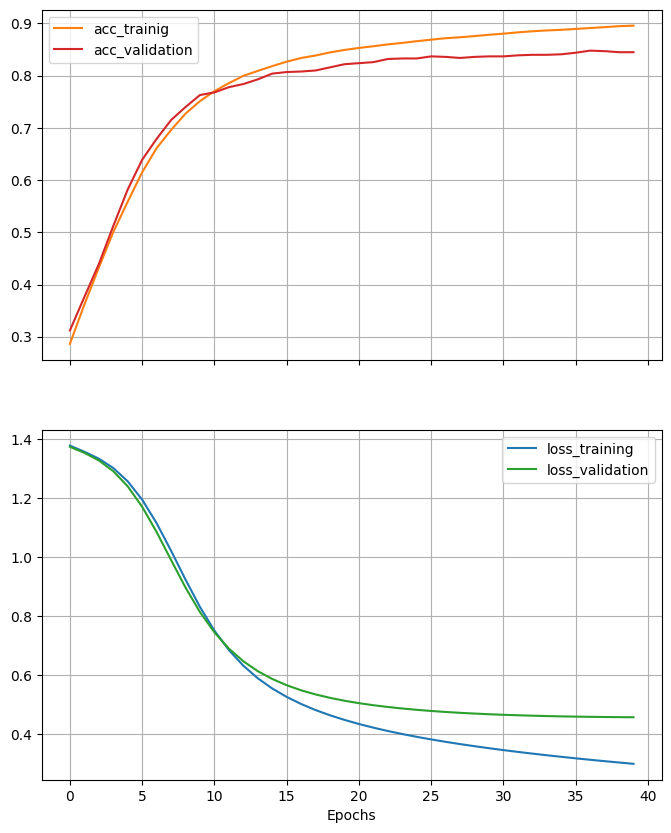

In [20]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):
    info = {'loss_training':loss_tr,'acc_trainig':acc_tr, 'loss_validation':loss_val, 'acc_validation':acc_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(8, 10), subplots=[('acc_trainig', 'acc_validation'), ('loss_training','loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [21]:
model.eval()
total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0

#[TO COMPLETE]
for idx, (label, text) in enumerate(dataloader_test):
      optimizer.zero_grad()
      logits = model(text)
      test_loss = criterion(logits, label)
      loss += test_loss
      test_loss.backward()
      optimizer.step()

      total_acc_test += (logits.argmax(1) == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1

      loss_test = loss/n_batches_test
      accuracy_test = total_acc_test/total_count_test
      
print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
print(f"Test Accuracy: {100*accuracy_test:.4f}%")

Test Loss: 0.44372845 ---------- Test Accuracy: 84.1000%


In [22]:
EPOCHS = 40
lr = 5e-4
overfit_model = FeedforwardNetwork(vocab_size, num_class, hidden_layers_dim=[128, 128]).to(device)
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=lr)
summary(overfit_model)

Layer (type:depth-idx)                   Param #
FeedforwardNetwork                       --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       128,128
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       516
Total params: 145,156
Trainable params: 145,156
Non-trainable params: 0

In [23]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(overfit_model, optimizer, dataloader_training, dataloader_validation)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 46.35%, Loss: 1.25775838 ---------------- Val_Acc: 64.50%, Val_Loss: 1.08645046
epoch: 2 -> Accuracy: 72.77%, Loss: 0.85431337 ---------------- Val_Acc: 76.10%, Val_Loss: 0.70470244
epoch: 3 -> Accuracy: 80.98%, Loss: 0.55560732 ---------------- Val_Acc: 80.00%, Val_Loss: 0.55761254
epoch: 4 -> Accuracy: 84.79%, Loss: 0.43403473 ---------------- Val_Acc: 81.40%, Val_Loss: 0.50781798
epoch: 5 -> Accuracy: 86.98%, Loss: 0.36767364 ---------------- Val_Acc: 81.90%, Val_Loss: 0.48881224
epoch: 6 -> Accuracy: 88.73%, Loss: 0.32205254 ---------------- Val_Acc: 82.10%, Val_Loss: 0.48246479
epoch: 7 -> Accuracy: 90.04%, Loss: 0.28639799 ---------------- Val_Acc: 82.30%, Val_Loss: 0.48217216
epoch: 8 -> Accuracy: 91.38%, Loss: 0.25620684 ---------------- Val_Acc: 82.70%, Val_Loss: 0.48588055
epoch: 9 -> Accuracy: 92.37%, Loss: 0.22952549 ---------------- Val_Acc: 83.30%, Val_Loss: 0.49176329
epoch: 10 -> Accuracy: 93.39%, Loss: 0.20514464 ---------------- Val_Acc: 83.00%, 

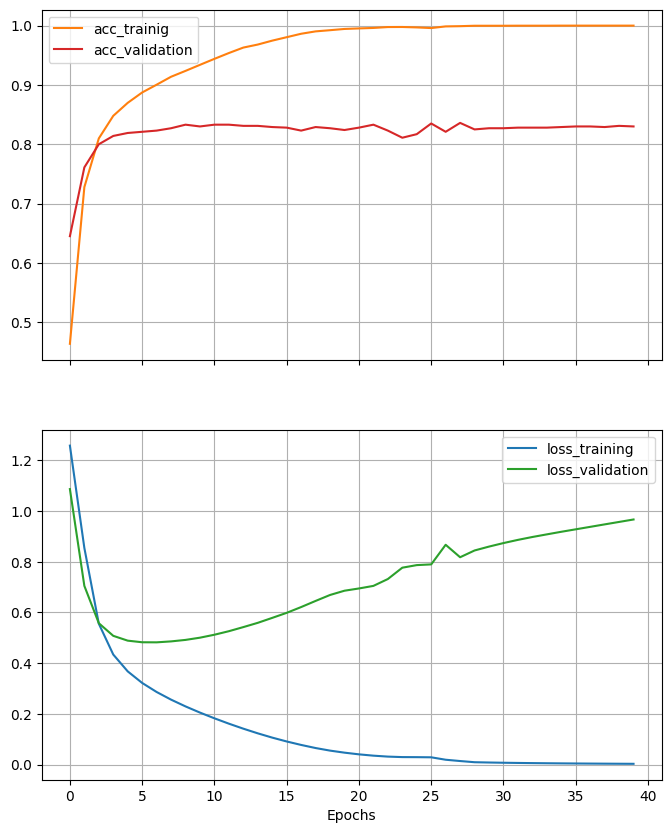

In [24]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [25]:
def train_L1(model, optimizer, dataloader_train, dataloader_val, l1_lambda=[0.001], EPOCHS=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(EPOCHS):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      ##########################################################
      #[TO COMPLETE]
      loss_with_l1 = loss + l1_lambda * np.sum(p.abs().sum() for p in model.parameters())
      ##########################################################
      total_loss_train += loss
      loss_with_l1.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [26]:
EPOCHS = 40
lr = 1e-4
overfit_model = FeedforwardNetwork(vocab_size, num_class, hidden_layers_dim=[256, 128, 64]).to(device)
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=lr)
summary(overfit_model)

Layer (type:depth-idx)                   Param #
FeedforwardNetwork                       --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       256,256
│    └─Linear: 2-2                       32,896
│    └─Linear: 2-3                       8,256
│    └─Linear: 2-4                       260
Total params: 297,668
Trainable params: 297,668
Non-trainable params: 0

In [27]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_L1(overfit_model, optimizer, dataloader_training, dataloader_validation, l1_lambda=0.001)
end = timer()
print(f"Training time in second: {(end - start)}")

C:\Users\elnur\AppData\Local\Temp\ipykernel_12440\1126079127.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  loss_with_l1 = loss + l1_lambda * np.sum(p.abs().sum() for p in model.parameters())


epoch: 1 -> Accuracy: 25.13%, Loss: 1.39757049 ---------------- Val_Acc: 27.40%, Val_Loss: 1.37952876
epoch: 2 -> Accuracy: 28.02%, Loss: 1.37667084 ---------------- Val_Acc: 31.50%, Val_Loss: 1.36883986
epoch: 3 -> Accuracy: 32.12%, Loss: 1.36678970 ---------------- Val_Acc: 34.40%, Val_Loss: 1.36000133
epoch: 4 -> Accuracy: 35.23%, Loss: 1.35659492 ---------------- Val_Acc: 37.70%, Val_Loss: 1.34997010
epoch: 5 -> Accuracy: 38.13%, Loss: 1.34441483 ---------------- Val_Acc: 40.90%, Val_Loss: 1.33735645
epoch: 6 -> Accuracy: 41.86%, Loss: 1.32902622 ---------------- Val_Acc: 43.10%, Val_Loss: 1.32095313
epoch: 7 -> Accuracy: 45.41%, Loss: 1.30871367 ---------------- Val_Acc: 45.90%, Val_Loss: 1.29909384
epoch: 8 -> Accuracy: 49.16%, Loss: 1.28219545 ---------------- Val_Acc: 49.70%, Val_Loss: 1.27057719
epoch: 9 -> Accuracy: 52.61%, Loss: 1.24840701 ---------------- Val_Acc: 53.40%, Val_Loss: 1.23419285
epoch: 10 -> Accuracy: 56.18%, Loss: 1.20554018 ---------------- Val_Acc: 57.00%, 

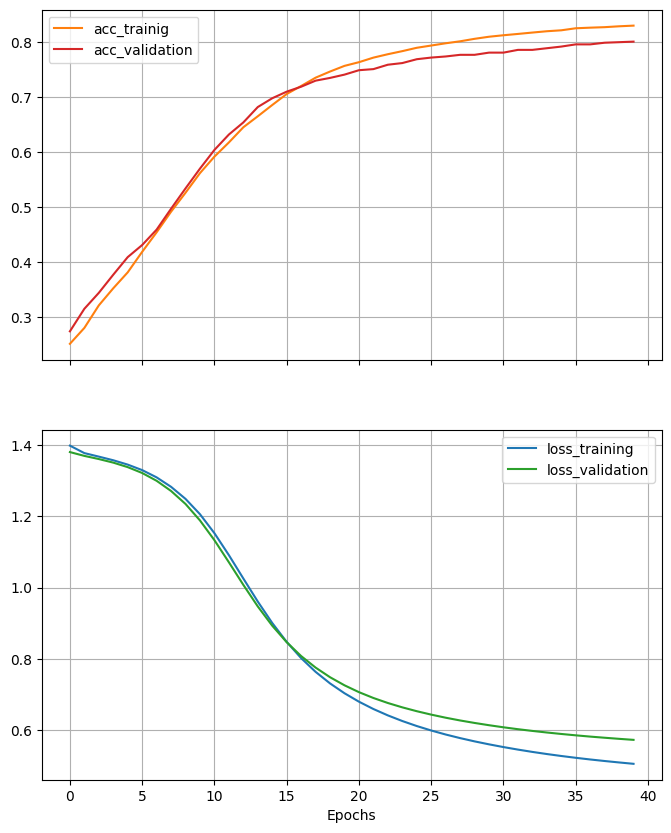

In [28]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [29]:
def train_L2(model, optimizer, dataloader_train, dataloader_val, l2_lambda=[0.001], EPOCHS=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(EPOCHS):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      ##########################################################
      #[TO COMPLETE]
      loss_with_l2 = loss + l2_lambda * np.sum(p.pow(2.0).sum() for p in model.parameters())
      ##########################################################
      total_loss_train += loss
      loss_with_l2.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [30]:
EPOCHS = 40
lr = 1e-4
overfit_model = FeedforwardNetwork(vocab_size, num_class, hidden_layers_dim=[256, 128, 64]).to(device)
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=lr)
summary(overfit_model)

Layer (type:depth-idx)                   Param #
FeedforwardNetwork                       --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       256,256
│    └─Linear: 2-2                       32,896
│    └─Linear: 2-3                       8,256
│    └─Linear: 2-4                       260
Total params: 297,668
Trainable params: 297,668
Non-trainable params: 0

In [31]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_L2(overfit_model, optimizer, dataloader_training, dataloader_validation, l2_lambda=0.01)
end = timer()
print(f"Training time in second: {(end - start)}")

C:\Users\elnur\AppData\Local\Temp\ipykernel_12440\872316655.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  loss_with_l2 = loss + l2_lambda * np.sum(p.pow(2.0).sum() for p in model.parameters())


epoch: 1 -> Accuracy: 24.20%, Loss: 1.39530039 ---------------- Val_Acc: 25.00%, Val_Loss: 1.38892102
epoch: 2 -> Accuracy: 27.37%, Loss: 1.38058901 ---------------- Val_Acc: 27.90%, Val_Loss: 1.37813306
epoch: 3 -> Accuracy: 31.01%, Loss: 1.37028980 ---------------- Val_Acc: 30.40%, Val_Loss: 1.36862159
epoch: 4 -> Accuracy: 34.39%, Loss: 1.36005962 ---------------- Val_Acc: 34.00%, Val_Loss: 1.35825193
epoch: 5 -> Accuracy: 38.29%, Loss: 1.34817278 ---------------- Val_Acc: 38.50%, Val_Loss: 1.34547830
epoch: 6 -> Accuracy: 42.06%, Loss: 1.33305693 ---------------- Val_Acc: 43.50%, Val_Loss: 1.32883823
epoch: 7 -> Accuracy: 46.06%, Loss: 1.31269503 ---------------- Val_Acc: 47.30%, Val_Loss: 1.30580974
epoch: 8 -> Accuracy: 50.33%, Loss: 1.28374541 ---------------- Val_Acc: 51.40%, Val_Loss: 1.27360046
epoch: 9 -> Accuracy: 54.95%, Loss: 1.24299562 ---------------- Val_Acc: 56.00%, Val_Loss: 1.22908390
epoch: 10 -> Accuracy: 58.69%, Loss: 1.18764484 ---------------- Val_Acc: 60.90%, 

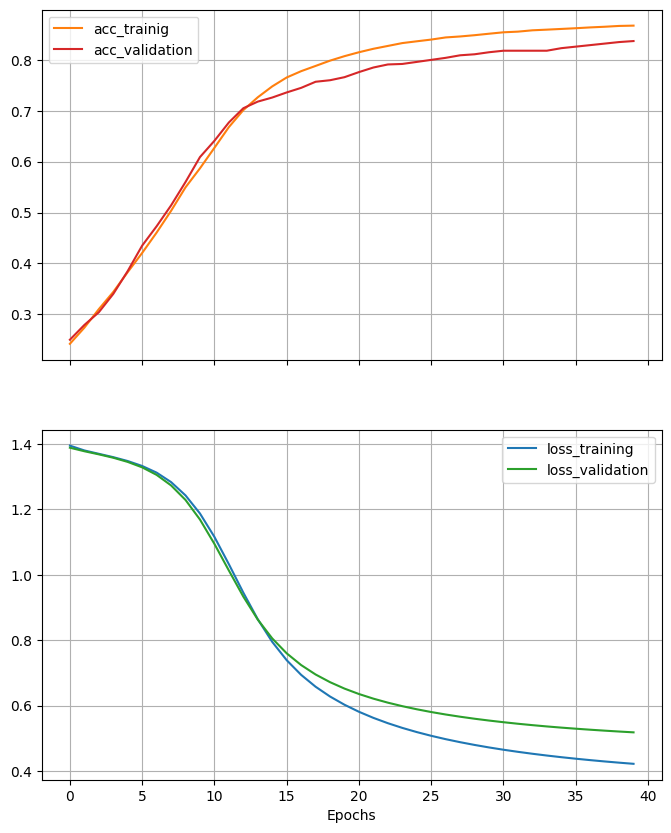

In [32]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [33]:
class EarlyStopping:
    def __init__(self, tolerance, min_delta):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
    
    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [34]:
def train_early_stop(model, optimizer, dataloader_train, dataloader_val, EPOCHS=EPOCHS):
  ###########################################################
  # instantiate an object of the EarlyStopping class
  tolerance = 2
  min_delta = 0.1
  estop = EarlyStopping(tolerance, min_delta) #[TO COMPLETE]
  ###########################################################
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(EPOCHS):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
    ############################################################
    # Use the EarlyStopping object
    estop(avg_loss_train, avg_loss_val)
    if estop.early_stop == True:
       break #[TO COMPLETE]
    ############################################################
  return loss_train, acc_train, loss_val, acc_val

In [35]:
EPOCHS = 40
lr = 1e-4
overfit_model = FeedforwardNetwork(vocab_size, num_class, hidden_layers_dim=[256, 128, 64]).to(device)
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=lr)
summary(overfit_model)

Layer (type:depth-idx)                   Param #
FeedforwardNetwork                       --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       256,256
│    └─Linear: 2-2                       32,896
│    └─Linear: 2-3                       8,256
│    └─Linear: 2-4                       260
Total params: 297,668
Trainable params: 297,668
Non-trainable params: 0

In [36]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_early_stop(overfit_model, optimizer, dataloader_training, dataloader_validation)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 31.29%, Loss: 1.37613893 ---------------- Val_Acc: 37.40%, Val_Loss: 1.34244061
epoch: 2 -> Accuracy: 44.49%, Loss: 1.30931675 ---------------- Val_Acc: 50.10%, Val_Loss: 1.27811599
epoch: 3 -> Accuracy: 56.81%, Loss: 1.22327638 ---------------- Val_Acc: 59.50%, Val_Loss: 1.17429161
epoch: 4 -> Accuracy: 65.37%, Loss: 1.09283578 ---------------- Val_Acc: 67.80%, Val_Loss: 1.03122282
epoch: 5 -> Accuracy: 71.65%, Loss: 0.92870802 ---------------- Val_Acc: 72.20%, Val_Loss: 0.87393421
epoch: 6 -> Accuracy: 75.78%, Loss: 0.76807588 ---------------- Val_Acc: 75.40%, Val_Loss: 0.74657434
epoch: 7 -> Accuracy: 79.00%, Loss: 0.64610606 ---------------- Val_Acc: 77.60%, Val_Loss: 0.66403604
epoch: 8 -> Accuracy: 81.06%, Loss: 0.56353843 ---------------- Val_Acc: 79.00%, Val_Loss: 0.61394501
epoch: 9 -> Accuracy: 82.83%, Loss: 0.50602275 ---------------- Val_Acc: 80.50%, Val_Loss: 0.58205265
epoch: 10 -> Accuracy: 84.09%, Loss: 0.46315953 ---------------- Val_Acc: 81.10%, 

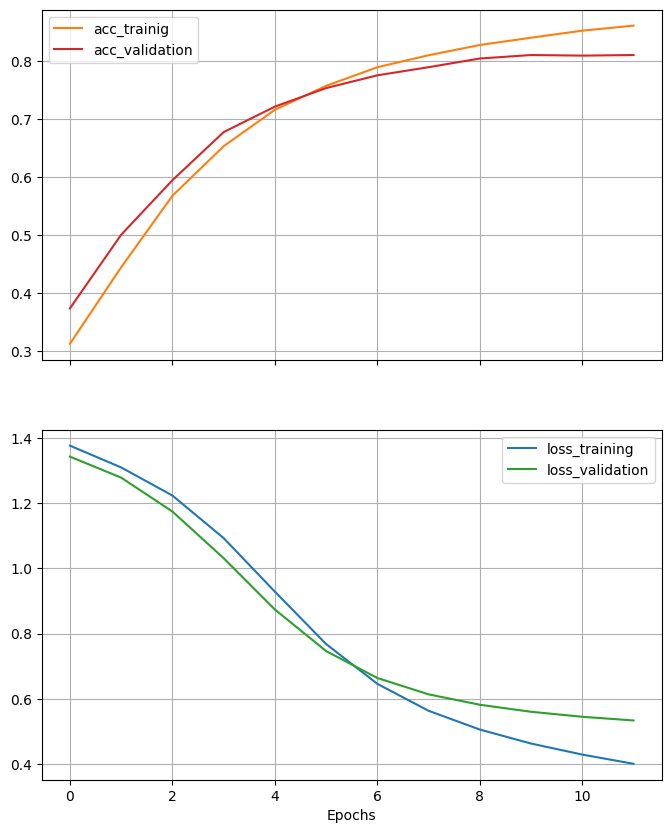

In [37]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [38]:
learning_rates = [1e-5, 1e-4, 1e-3]

In [39]:
stack = []
for lr in learning_rates:
  print(f"Learning Rate: {lr}")
  model = FeedforwardNetwork(vocab_size, num_class, hidden_layers_dim=[128, 64]).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  stack.append(train(model, optimizer, dataloader_training, dataloader_validation, EPOCHS=15))
  print("-"*50)

Learning Rate: 1e-05
epoch: 1 -> Accuracy: 25.84%, Loss: 1.39514232 ---------------- Val_Acc: 27.60%, Val_Loss: 1.38997400
epoch: 2 -> Accuracy: 26.69%, Loss: 1.39111042 ---------------- Val_Acc: 28.10%, Val_Loss: 1.38635588
epoch: 3 -> Accuracy: 27.58%, Loss: 1.38728845 ---------------- Val_Acc: 29.30%, Val_Loss: 1.38279700
epoch: 4 -> Accuracy: 28.38%, Loss: 1.38352358 ---------------- Val_Acc: 30.10%, Val_Loss: 1.37928605
epoch: 5 -> Accuracy: 29.02%, Loss: 1.37979674 ---------------- Val_Acc: 30.80%, Val_Loss: 1.37581563
epoch: 6 -> Accuracy: 29.76%, Loss: 1.37609637 ---------------- Val_Acc: 31.80%, Val_Loss: 1.37236667
epoch: 7 -> Accuracy: 30.60%, Loss: 1.37241280 ---------------- Val_Acc: 32.30%, Val_Loss: 1.36892200
epoch: 8 -> Accuracy: 31.37%, Loss: 1.36873865 ---------------- Val_Acc: 33.00%, Val_Loss: 1.36547303
epoch: 9 -> Accuracy: 32.42%, Loss: 1.36505795 ---------------- Val_Acc: 33.90%, Val_Loss: 1.36200953
epoch: 10 -> Accuracy: 33.29%, Loss: 1.36135733 -------------

Learning Rate: 1e-05


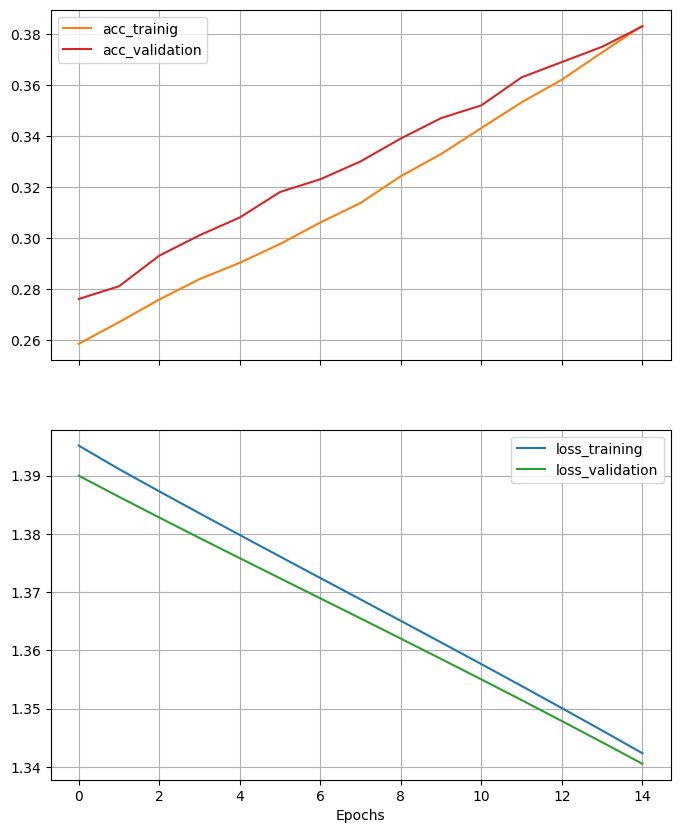

Learning Rate: 0.0001


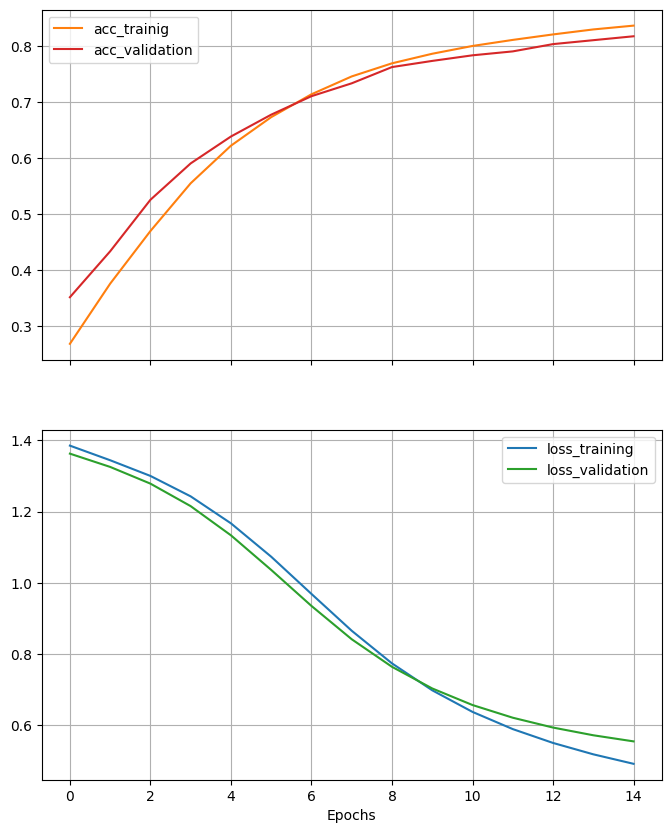

Learning Rate: 0.001


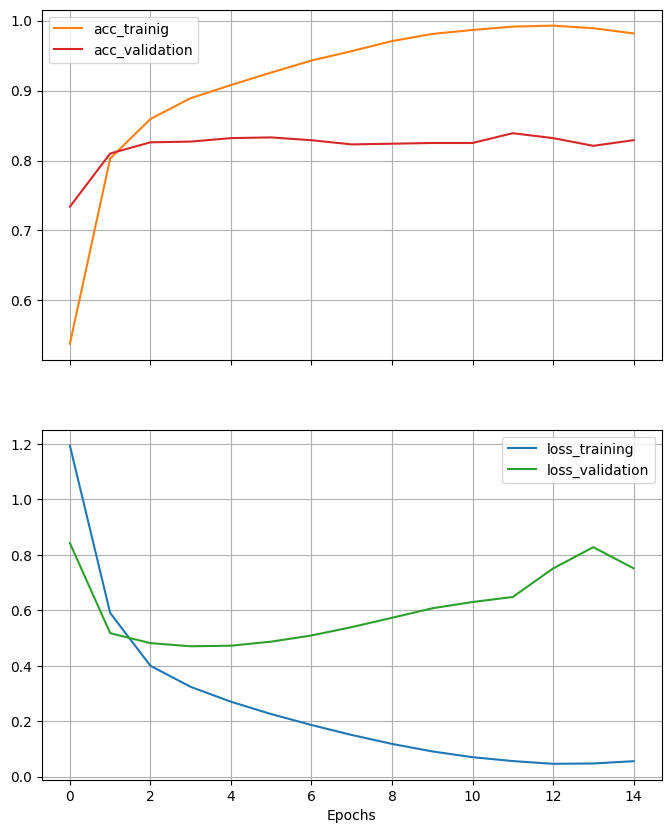

In [40]:
# Let's plot the results
for idx, el in enumerate(stack):
  print(f"Learning Rate: {learning_rates[idx]}")
  plot_learning_acc_and_loss(*el)

In [19]:
model = NeuralNetClassifier(
    module=FeedforwardNetwork,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    max_epochs=2)

# we need to adapt PyTorch Dataset to work with Scikit-Learn GridSearchCV
# we use the SliceDataset class from skorch package for this purpose
X_slice = SliceDataset(train_dataset, idx=1)
y_slice = SliceDataset(train_dataset, idx=0)

In [20]:
params = {
    'lr': [1e-4, 1e-3], #[TO COMPLETE],
    'module__input_dim': [1000], #[TO COMPLETE],
    'module__num_classes': [4], #[TO COMPLETE],
    'module__hidden_layers_dim': [[64, 64], [64, 128], [128, 64], [128, 128]] #[TO COMPLETE], 
    }

In [21]:
n_jobs = multiprocessing.cpu_count()-1
gs = GridSearchCV(model, params, n_jobs=n_jobs)

In [22]:
outputs = gs.fit(X_slice, y_slice)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.0409       0.7835        0.6503  13.3105
      2        0.4780       0.8280        0.4944  13.6157


In [34]:
best_sc = (outputs.best_score_)
best_par = outputs.best_params_
print(f"best score: {best_sc:.3f}, best params: {best_par.values()}".format()) #[TO COMPLETE]

best score: 0.816, best params: dict_values([0.001, [128, 64], 1000, 4])


In [32]:
# Test the model
X_test = SliceDataset(test_dataset, idx=1)
y_test = SliceDataset(test_dataset, idx=0)
pred = outputs.best_estimator_.predict(X_test)
model_score = outputs.best_estimator_.score(X_test, y_test)
print(model_score*100,'%') #[TO COMPLETE]

83.6 %
